In [5]:
!pip install albumentations ptflops transformers timm --quiet

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from tqdm import tqdm

# ===== Dataset Class =====
class ChestCTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, start_idx, end_idx, transform=None):
        self.transform = transform

        image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        def base_image(fname):
            return os.path.splitext(fname)[0]

        def base_mask(fname):
            return os.path.splitext(fname)[0].replace("_mask", "")

        img_map = {base_image(f): f for f in image_files}
        mask_map = {base_mask(f): f for f in mask_files}

        common = sorted(set(img_map.keys()) & set(mask_map.keys()))
        total = len(common)
        if total == 0:
            raise ValueError("No matching image–mask pairs found. Check filename patterns.")
        if end_idx > total:
            end_idx = total
        if start_idx >= end_idx:
            raise ValueError("`start_idx` must be less than `end_idx`")

        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_map = img_map
        self.mask_map = mask_map
        self.images = common[start_idx:end_idx]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]
        img = cv2.imread(os.path.join(self.image_dir, self.image_map[name]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = np.stack([img]*3, axis=-1)

        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_map[name]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        img = torch.tensor(img.astype(np.float32) / 255.).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)
        return img, mask

# ===== Paths =====
img_dir = "/kaggle/input/chest-ct-segmentation/images/images"
mask_dir = "/kaggle/input/chest-ct-segmentation/masks/masks"

# ===== Transforms =====
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
])

# ===== Prepare Dataset =====
# Count matching pairs
temp_img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
temp_mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
temp_common = sorted(
    set([os.path.splitext(f)[0] for f in temp_img_files]) &
    set([os.path.splitext(f)[0].replace("_mask", "") for f in temp_mask_files])
)
total_common = len(temp_common)
print(f"Found {total_common} matching pairs.")

train_end = int(total_common * 0.8)
train_ds = ChestCTDataset(img_dir, mask_dir, 0, train_end, transform)
test_ds = ChestCTDataset(img_dir, mask_dir, train_end, total_common)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

# ===== Model =====
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2, # background + lung
    ignore_mismatched_sizes=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ===== Loss & Optimizer =====
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# ===== Training =====
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(pixel_values=imgs, labels=masks)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

# ===== Save Model =====
torch.save(model.state_dict(), "segformer_chestct.pth")
print("Training complete. Model saved as segformer_chestct.pth")


Found 16708 matching pairs.


/tmp/ipykernel_36/1595913215.py:75: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 3342/3342 [09:23<00:00,  5.93it/s]


Epoch 1 - Loss: 0.1170


Epoch 2/5: 100%|██████████| 3342/3342 [08:51<00:00,  6.29it/s]


Epoch 2 - Loss: 0.0590


Epoch 3/5: 100%|██████████| 3342/3342 [09:13<00:00,  6.03it/s]


Epoch 3 - Loss: 0.0471


Epoch 5/5: 100%|██████████| 3342/3342 [08:31<00:00,  6.53it/s]

Epoch 5 - Loss: 0.0379
Training complete. Model saved as segformer_chestct.pth


In [9]:
import torch
import torch.nn.functional as F
from torchmetrics import JaccardIndex
from ptflops import get_model_complexity_info

def evaluate_model_segformer(model, test_loader, device):
    model.eval()
    miou_metric = JaccardIndex(task="binary", threshold=0.5).to(device)
    total_time = 0

    with torch.no_grad():
        for img, mask in test_loader:
            img, mask = img.to(device), mask.to(device)

            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()

            outputs = model(pixel_values=img)  # SegFormer forward
            preds = torch.argmax(outputs.logits, dim=1).unsqueeze(1).float()  # [B,1,H,W]

            # Resize predictions to match mask size
            preds = F.interpolate(preds, size=mask.shape[-2:], mode="nearest")

            end.record()
            torch.cuda.synchronize()
            total_time += start.elapsed_time(end)

            # Match shapes for metric
            mask = mask.unsqueeze(1).float()

            miou_metric.update(preds, mask)

    # FLOPs calculation
    flops, _ = get_model_complexity_info(
        model,
        (3, 256, 256),
        as_strings=False,
        print_per_layer_stat=False
    )

    return {
        'mIoU': miou_metric.compute().item(),
        'FLOPs': flops,
        'Inference Time': total_time / len(test_loader.dataset)
    }


In [17]:
# ===== Visualization =====
def visualize_predictions(model, loader, num_images=3):
    model.eval()
    imgs_shown = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(pixel_values=imgs)

            # Resize to mask size
            logits = outputs.logits
            logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(logits, dim=1)

            for i in range(imgs.size(0)):
                img = imgs[i].permute(1, 2, 0).cpu().numpy()
                mask_true = masks[i].cpu().numpy()
                mask_pred = preds[i].cpu().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(mask_true, cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(mask_pred, cmap="gray")
                axs[2].set_title("Prediction")
                axs[2].axis("off")

                plt.show()

                imgs_shown += 1
                if imgs_shown >= num_images:
                    return

In [20]:
metrics = evaluate_model_segformer(model, test_loader, device)
print(f"Validation mIoU: {metrics['mIoU']:.4f}")
print(f"FLOPs: {metrics['FLOPs'] / 1e6:.2f} MFLOPs")
print(f"Average Inference Time: {metrics['Inference Time']:.4f} ms/image")




Validation mIoU: 0.7873
FLOPs: 1765.10 MFLOPs
Average Inference Time: 3.3572 ms/image


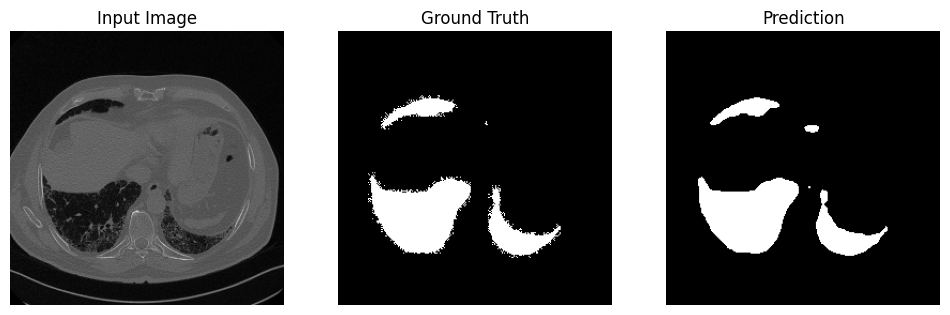

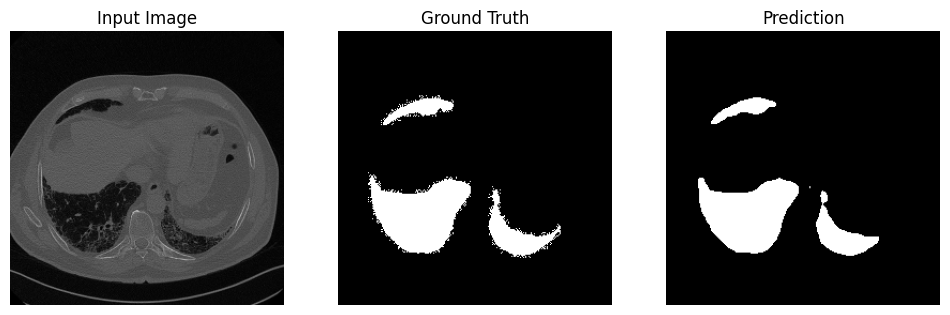

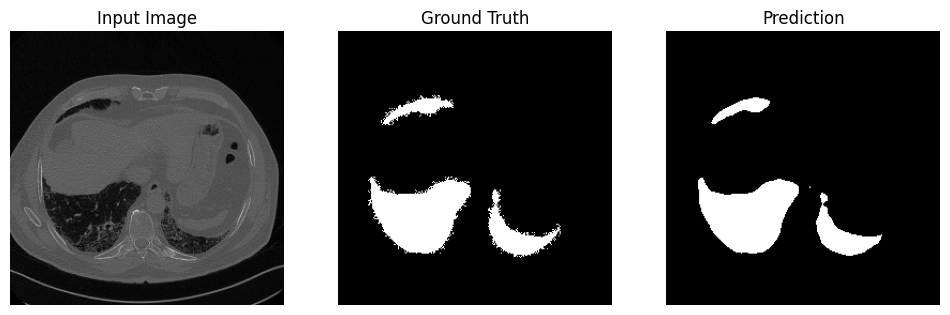

In [19]:
import matplotlib.pyplot as plt
visualize_predictions(model, test_loader)